In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import fastai as fai
import fastai.vision as faiv
import fastai.callbacks as faic
from data.load import get_data, subsample
from model.metrics import psnr, ssim

## Choose Devices

In [4]:
gpu_id = 3
num_cores = 4

In [5]:
faiv.torch.cuda.set_device(gpu_id)

## Set Experiment Name

In [6]:
nb_name = 'feature_loss_baseline'

## Load Data

In [7]:
bs = 8  # batch size
size = 512  # image size
data_pth = faiv.Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
lr_dir = f'EM/training/trainsets/lr/'  # input images
hr_dir = f'EM/training/trainsets/hr/'  # target images
model_pth = data_pth/f'EM/models/baselines'  # path to saved models
print(data_pth)  # confirm data path
print(model_pth) # confirm model path

/home/alaa/Dropbox/BPHO Staff/USF
/home/alaa/Dropbox/BPHO Staff/USF/EM/models/baselines


In [8]:
# Create databunch
data = get_data(data_pth, lr_dir, hr_dir, bs, 
                in_sz=size, out_sz=size, max_zoom=3)

In [9]:
# Dataset sizes
len(data.train_ds), len(data.valid_ds)

(79998, 19999)

In [10]:
# Batch size and number of batches
data.batch_size, len(data.train_dl)

(8, 9999)

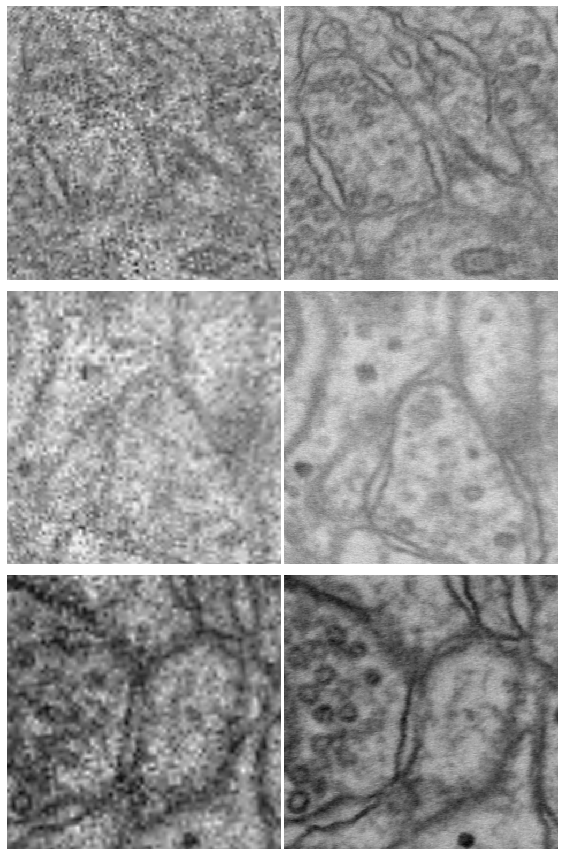

In [11]:
# Data Visualization
data.show_batch(rows=3)

## Data Subsample

In [12]:
data = subsample(data)

In [13]:
data.c

3

In [14]:
# Dataset sizes
len(data.train_dl), len(data.valid_dl)

(999, 250)

In [15]:
# Batch size and number of batches
data.batch_size

8

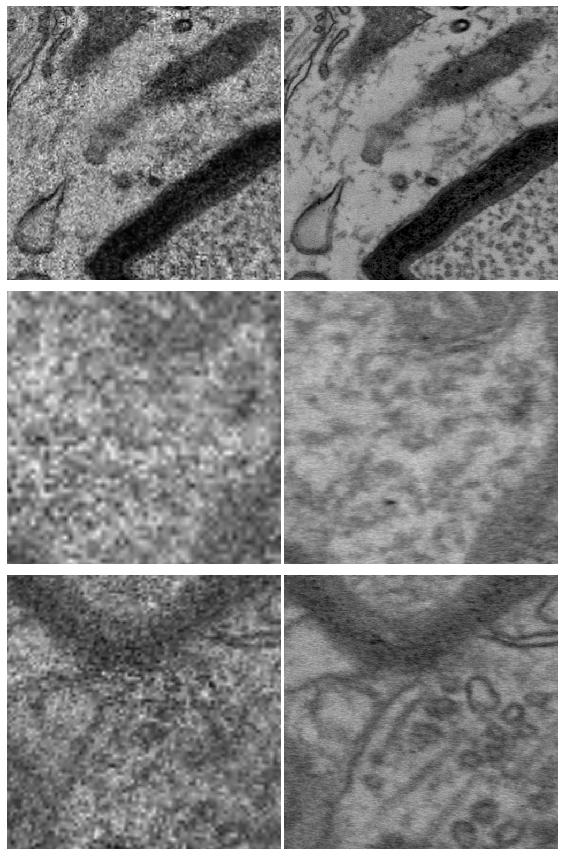

In [16]:
# Data Visualization
data.show_batch(rows=3)

## Feature Loss

In [17]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [18]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = faic.hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [19]:
vgg_m = faiv.models.vgg16_bn(True).features.cuda().eval()
faiv.requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(faiv.children(vgg_m)) if isinstance(o, nn.MaxPool2d)]

In [20]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# Model

## Initialization

In [48]:
arch = faiv.models.resnet34
wd = 1e-3
metrics = [F.mse_loss, psnr, ssim]
learn = faiv.unet_learner(data, arch, wd=wd, 
                         loss_func=feat_loss,
                         #loss_func=F.mse_loss,
                         metrics=metrics, 
                         #callback_fns=LossMetrics, 
                         blur=True, 
                         norm_type=faiv.NormType.Weight, 
                         model_dir=model_pth)
faiv.gc.collect()

8

In [49]:
learn.model_dir = model_pth
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/baselines


## Load Model (optional)

In [50]:
learn.model_dir = model_pth
learn = learn.load(f'{nb_name}.1b')

## Validate Loaded Model

In [31]:
learn.validate()

[0.8182099, tensor(0.0660), tensor(11.8202), tensor(0.2618)]

In [24]:
learn.data.valid_dl = learn.data.valid_dl.new(shuffle=False)

In [51]:
learn.show_results(rows=1)

AttributeError: 'tuple' object has no attribute 'apply_tfms'

In [26]:
batch = learn.data.one_batch(ds_type=faiv.DatasetType.Valid)

In [27]:
batch = (batch[0].cuda(), batch[1].cuda())

In [42]:
preds = learn.pred_batch(batch)

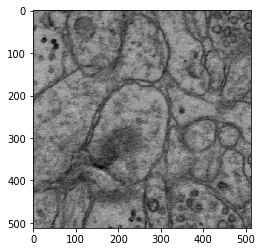

In [45]:
plt.imshow(batch[1][0].permute(1,2,0))

## Training

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

### 1a

In [ ]:
lr = 1e-3
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}_baseline.1a', with_opt=False)

In [ ]:
learn.validate()

In [ ]:
learn.show_results()

### 1b

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}_baseline.1b', with_opt=False)

In [ ]:
learn.show_results()

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = slice(3e-4, 3e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}_baseline.1c', with_opt=False)

In [ ]:
learn.validate()

In [ ]:
learn.show_results()

In [ ]:
learn.recorder.plot_losses()